In [1]:
import os 
os.chdir(r'Q:\sachuriga\Sachuriga_Python/quattrocolo-nwb4fp\src')

from neurochat.nc_data import NData
from neurochat.nc_spike import NSpike
from neurochat.nc_spatial import NSpatial
import neurochat.nc_plot as nc_plot
from neurochat.nc_lfp import NLfp
import matplotlib.pyplot as plt
import numpy as np
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import numpy as np
import math
import pynapple as nap
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

import sys
import nwb4fp.analyses.maps as mapp
from nwb4fp.analyses.examples.tracking_plot import plot_ratemap,plot_path
from nwb4fp.analyses.fields import separate_fields_by_laplace, separate_fields_by_dilation,find_peaks,separate_fields_by_laplace_of_gaussian,calculate_field_centers,distance_to_edge_function, remove_fields_by_area, map_pass_to_unit_circle,which_field,compute_crossings
from elephant.statistics import time_histogram, instantaneous_rate
from nwb4fp.analyses import maps
from nwb4fp.analyses.data import pos2speed,speed_filtered_spikes,load_speed_fromNWB,load_units_fromNWB,get_filed_num,unit_location_ch
from scipy.ndimage import gaussian_filter
import ast
import pandas as pd
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=np.inf)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import seaborn as sns
from itertools import chain
import pandas as pd
from nwb4fp.data.helpers import df2results, df2results_sns

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os

# Directory containing NWB files
folder_path = r"S:\Sachuriga/nwb/test4neo/"

# Lists to store results
results = []

# Loop through all .nwb files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.nwb'):
        filepath = os.path.join(folder_path, filename)
        
        # Extract animal_id and session from filename
        animal_id = filename.split("neo/")[-1][:5] if "neo/" in filename else filename[:5]
        session = filename.split("_phy")[0][-1] if "_phy" in filename else "unknown"
        
        # try:
            # Load data
        npdata = nap.load_file(filepath)
        pos_cord = load_speed_fromNWB(npdata['XY_mid_brain'])

        # Process position and speed data
        raw_pos, combined_array, mask, speeds, smoothed_speed, filtered_speed = pos2speed(
            pos_cord[:,0], pos_cord[:,1], pos_cord[:,2],
            filter_speed=True, min_speed=0.05
        )
        combined_array = raw_pos
        combined_array[np.isnan(combined_array)] = 0
        smoothed_speed[np.isnan(smoothed_speed)] = 0

        # Create bins for heatmap
        x_bins = np.linspace(min(combined_array[:,1]), max(combined_array[:,1]), 51)
        y_bins = np.linspace(min(combined_array[:,2]), max(combined_array[:,2]), 51)

        # Calculate speed heatmap
        speed_heatmap = np.zeros((len(x_bins)-1, len(y_bins)-1))
        counts = np.zeros((len(x_bins)-1, len(y_bins)-1))
        counts1 = np.zeros((len(x_bins)-1, len(y_bins)-1))
        
        for i in range(len(combined_array)):
            x_idx = np.searchsorted(x_bins, combined_array[i,1]) - 1
            y_idx = np.searchsorted(y_bins, combined_array[i,2]) - 1
            if 0 <= x_idx < len(x_bins)-1 and 0 <= y_idx < len(y_bins)-1:
                speed_heatmap[x_idx, y_idx] += smoothed_speed[i]
                counts[x_idx, y_idx] += 100/len(combined_array)
                counts1[x_idx, y_idx] += 1

        # Process heatmaps
        speed_heatmap = np.divide(speed_heatmap, counts1, where=counts!=0) * 50
        speed_heatmap[counts1 == 0] = np.nan
        speed_heatmap_smoothed = gaussian_filter(speed_heatmap, sigma=2)
        H_counts_smoothed = gaussian_filter(counts, sigma=2)

        # Calculate metrics
        active_times = len(smoothed_speed[smoothed_speed>=0.05])/len(smoothed_speed)
        
        center_x_min, center_x_max = 0.25, 0.75
        center_y_min, center_y_max = 0.25, 0.75
        
        df = pd.DataFrame({'x': combined_array[:,1], 'y': combined_array[:,2]})
        df['in_center'] = (
            (df['x'] >= center_x_min) & (df['x'] <= center_x_max) & 
            (df['y'] >= center_y_min) & (df['y'] <= center_y_max)
        ).astype(int)

        time_in_center = len(np.where(df['in_center'] == 1)[0])/len(df)
        mean_speed = np.mean(smoothed_speed)*50
        
        speed_in_center = smoothed_speed[df['in_center'] == 1]
        speed_in_edge = smoothed_speed[df['in_center'] == 0]
        filter_speed_in_center = speed_in_center
        filter_speed_in_edge = speed_in_edge
        
        center_border_ratio = np.mean(filter_speed_in_center)/np.mean(filter_speed_in_edge)

        # Store results
        results.append({
            'filename': filename,
            'animal_id': animal_id,
            'session': session,
            'filter_speed_in_center': np.mean(filter_speed_in_center)*50,
            'filter_speed_in_edge': np.mean(filter_speed_in_edge)*50,
            'center_border_ratio': center_border_ratio,
            'active_times': active_times,
            'mean_speed': mean_speed,
            'smoothed_speed': smoothed_speed,
            'time_in_center': time_in_center,
            'H_counts_smoothed': H_counts_smoothed,
            'speed_heatmap_smoothed': speed_heatmap_smoothed,
            'x':df['x'],
            'y':df['y']
        })

        print(f"Processed: {filename}")
        print(f"speed in center: {np.mean(filter_speed_in_center)*50:.2f} cm/s")
        print(f"speed in border: {np.mean(filter_speed_in_edge)*50:.2f} cm/s")
        print(f"center/border speed ratio: {center_border_ratio:.2f}")
        print(f"animal is active during: {active_times*100:.2f}% of time")
        print(f"Average speed is: {mean_speed:.2f} cm/s")
        print(f"time in center: {time_in_center*100:.2f}%")
        print("-" * 50)

        # except Exception as e:
        #     print(f"Error processing {filename}: {str(e)}")
        #     continue

# Convert results to DataFrame for easy analysis
results_df = pd.DataFrame([{
    'filename': r['filename'],
    'animal_id': r['animal_id'],
    'session': r['session'],
    'filter_speed_in_center': r['filter_speed_in_center'],
    'filter_speed_in_edge': r['filter_speed_in_edge'],
    'center_border_ratio': r['center_border_ratio'],
    'active_times': r['active_times'],
    'mean_speed': r['mean_speed'],
    'smoothed_speed':r['smoothed_speed'],
    'time_in_center': r['time_in_center'],
    'H_counts_smoothed': r['H_counts_smoothed'],
    'speed_heatmap_smoothed': r['speed_heatmap_smoothed'],
    'x':r['x'],
    'y':r['y']
} for r in results])

# Save results to CSV (optional)
results_df.to_csv('S:/Sachuriga/nwb/test4neo/test/speed_analysis_results.csv', index=False)
results_df.to_pickle('S:/Sachuriga/nwb/test4neo/test/speed_analysis_results.pkl')

# You can access the heatmaps separately from the results list
# For example: results[0]['H_counts_smoothed'] for the first file's time heatmap

Processed: 66922_2024-09-25_15-39-48_A_phy_k_manual.nwb
speed in center: 7.76 cm/s
speed in border: 7.38 cm/s
center/border speed ratio: 1.05
animal is active during: 87.40% of time
Average speed is: 7.46 cm/s
time in center: 20.41%
--------------------------------------------------
Processed: 63383_2024-07-10_15-37-51_A_phy_k_manual.nwb
speed in center: 6.88 cm/s
speed in border: 6.92 cm/s
center/border speed ratio: 0.99
animal is active during: 84.15% of time
Average speed is: 6.92 cm/s
time in center: 17.71%
--------------------------------------------------
Processed: 63383_2024-07-13_14-10-05_A_phy_k_manual.nwb
speed in center: 5.78 cm/s
speed in border: 6.61 cm/s
center/border speed ratio: 0.87
animal is active during: 81.45% of time
Average speed is: 6.43 cm/s
time in center: 22.03%
--------------------------------------------------
Processed: 63383_2024-07-13_14-42-37_B_phy_k_manual.nwb
speed in center: 7.13 cm/s
speed in border: 7.57 cm/s
center/border speed ratio: 0.94
animal

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 63383_2024-07-15_14-51-19_A_phy_k_manual.nwb
speed in center: 5.40 cm/s
speed in border: 6.11 cm/s
center/border speed ratio: 0.88
animal is active during: 74.68% of time
Average speed is: 5.97 cm/s
time in center: 18.95%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 63383_2024-07-15_15-18-02_B_phy_k_manual.nwb
speed in center: 6.46 cm/s
speed in border: 6.15 cm/s
center/border speed ratio: 1.05
animal is active during: 79.19% of time
Average speed is: 6.20 cm/s
time in center: 15.42%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 63383_2024-07-15_15-44-58_C_phy_k_manual.nwb
speed in center: 8.46 cm/s
speed in border: 8.54 cm/s
center/border speed ratio: 0.99
animal is active during: 89.20% of time
Average speed is: 8.52 cm/s
time in center: 23.12%
--------------------------------------------------
Processed: 63383_2024-07-18_14-13-10_A_phy_k_manual.nwb
speed in center: 9.57 cm/s
speed in border: 10.72 cm/s
center/border speed ratio: 0.89
animal is active during: 90.14% of time
Average speed is: 10.42 cm/s
time in center: 25.46%
--------------------------------------------------
Processed: 63383_2024-07-18_14-39-54_B_phy_k_manual.nwb
speed in center: 8.72 cm/s
speed in border: 8.73 cm/s
center/border speed ratio: 1.00
animal is active during: 88.30% of time
Average speed is: 8.73 cm/s
time in center: 17.20%
--------------------------------------------------
Processed: 63383_2024-07-18_15-07-00_C_phy_k_manual.nwb
speed in center: 8.33 cm/s
speed in border: 9.52 cm/s
center/border speed ratio: 0.88
anim

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 65165_2023-06-30_16-32-08_A_phy_k_manual.nwb
speed in center: 9.68 cm/s
speed in border: 7.16 cm/s
center/border speed ratio: 1.35
animal is active during: 81.52% of time
Average speed is: 7.47 cm/s
time in center: 12.47%
--------------------------------------------------
Processed: 65165_2023-07-01_15-38-12_A_phy_k_manual.nwb
speed in center: 11.55 cm/s
speed in border: 8.34 cm/s
center/border speed ratio: 1.39
animal is active during: 88.41% of time
Average speed is: 8.77 cm/s
time in center: 13.52%
--------------------------------------------------
Processed: 65165_2023-07-03_16-21-48_A_phy_k_manual.nwb
speed in center: 10.16 cm/s
speed in border: 8.02 cm/s
center/border speed ratio: 1.27
animal is active during: 83.61% of time
Average speed is: 8.29 cm/s
time in center: 12.70%
--------------------------------------------------
Processed: 65165_2023-07-04_13-41-46_A_phy_k_manual.nwb
speed in center: 10.07 cm/s
speed in border: 7.06 cm/s
center/border speed ratio: 1.43
ani

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 65165_2023-07-10_15-08-59_A_phy_k_manual.nwb
speed in center: 6.16 cm/s
speed in border: 6.50 cm/s
center/border speed ratio: 0.95
animal is active during: 81.25% of time
Average speed is: 6.40 cm/s
time in center: 29.23%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 65165_2023-07-10_16-19-04_B_phy_k_manual.nwb
speed in center: 12.35 cm/s
speed in border: 9.94 cm/s
center/border speed ratio: 1.24
animal is active during: 93.20% of time
Average speed is: 10.57 cm/s
time in center: 26.04%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 65165_2023-07-10_17-11-32_C_phy_k_manual.nwb
speed in center: 8.94 cm/s
speed in border: 7.66 cm/s
center/border speed ratio: 1.17
animal is active during: 85.38% of time
Average speed is: 7.86 cm/s
time in center: 15.09%
--------------------------------------------------
Processed: 65165_2023-07-19_13-24-38_A_phy_k_manual.nwb
speed in center: 8.34 cm/s
speed in border: 5.37 cm/s
center/border speed ratio: 1.55
animal is active during: 74.24% of time
Average speed is: 5.64 cm/s
time in center: 9.11%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 65165_2023-07-20_16-57-26_A_phy_k_manual.nwb
speed in center: 9.81 cm/s
speed in border: 6.18 cm/s
center/border speed ratio: 1.59
animal is active during: 76.54% of time
Average speed is: 6.47 cm/s
time in center: 8.21%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 65165_2023-07-25_14-02-32_A_phy_k_manual.nwb
speed in center: 8.56 cm/s
speed in border: 5.94 cm/s
center/border speed ratio: 1.44
animal is active during: 76.33% of time
Average speed is: 6.17 cm/s
time in center: 8.77%
--------------------------------------------------
Processed: 65165_2023-07-26_14-32-28_A_phy_k_manual.nwb
speed in center: 10.86 cm/s
speed in border: 7.67 cm/s
center/border speed ratio: 1.42
animal is active during: 84.40% of time
Average speed is: 8.11 cm/s
time in center: 13.74%
--------------------------------------------------
Processed: 65165_2023-07-29_15-34-20_A_phy_k_manual.nwb
speed in center: 11.92 cm/s
speed in border: 8.08 cm/s
center/border speed ratio: 1.47
animal is active during: 85.88% of time
Average speed is: 8.55 cm/s
time in center: 12.12%
--------------------------------------------------
Processed: 65588_2024-03-04_15-44-37_A_phy_k_manual.nwb
speed in center: 8.66 cm/s
speed in border: 8.32 cm/s
center/border speed ratio: 1.04
anima

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 65588_2024-03-04_17-12-55_C_phy_k_manual.nwb
speed in center: 11.54 cm/s
speed in border: 11.09 cm/s
center/border speed ratio: 1.04
animal is active during: 95.50% of time
Average speed is: 11.23 cm/s
time in center: 29.29%
--------------------------------------------------
Processed: 65588_2024-03-06_15-45-53_A_phy_k_manual.nwb
speed in center: 9.89 cm/s
speed in border: 9.12 cm/s
center/border speed ratio: 1.09
animal is active during: 86.56% of time
Average speed is: 9.29 cm/s
time in center: 22.64%
--------------------------------------------------
Processed: 65588_2024-03-06_16-25-11_B_phy_k_manual.nwb
speed in center: 11.30 cm/s
speed in border: 10.23 cm/s
center/border speed ratio: 1.10
animal is active during: 92.59% of time
Average speed is: 10.48 cm/s
time in center: 23.06%
--------------------------------------------------
Processed: 65588_2024-03-06_16-56-57_C_phy_k_manual.nwb
speed in center: 10.97 cm/s
speed in border: 10.84 cm/s
center/border speed ratio: 1.0

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 65588_2024-03-10_15-18-16_A_phy_k_manual.nwb
speed in center: 14.37 cm/s
speed in border: 12.09 cm/s
center/border speed ratio: 1.19
animal is active during: 92.44% of time
Average speed is: 12.45 cm/s
time in center: 15.64%
--------------------------------------------------
Processed: 65588_2024-03-10_15-48-31_B_phy_k_manual.nwb
speed in center: 11.65 cm/s
speed in border: 10.07 cm/s
center/border speed ratio: 1.16
animal is active during: 84.52% of time
Average speed is: 10.30 cm/s
time in center: 14.74%
--------------------------------------------------
Processed: 65588_2024-03-10_16-17-14_C_phy_k_manual.nwb
speed in center: 11.70 cm/s
speed in border: 12.40 cm/s
center/border speed ratio: 0.94
animal is active during: 89.84% of time
Average speed is: 12.24 cm/s
time in center: 22.28%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 65588_2024-03-12_15-17-04_A_phy_k_manual.nwb
speed in center: 11.02 cm/s
speed in border: 10.67 cm/s
center/border speed ratio: 1.03
animal is active during: 91.28% of time
Average speed is: 10.73 cm/s
time in center: 18.80%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 65588_2024-03-12_15-44-58_B_phy_k_manual.nwb
speed in center: 10.59 cm/s
speed in border: 9.84 cm/s
center/border speed ratio: 1.08
animal is active during: 89.44% of time
Average speed is: 10.02 cm/s
time in center: 23.51%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 65588_2024-03-12_16-15-30_C_phy_k_manual.nwb
speed in center: 12.12 cm/s
speed in border: 10.55 cm/s
center/border speed ratio: 1.15
animal is active during: 88.00% of time
Average speed is: 10.74 cm/s
time in center: 12.15%
--------------------------------------------------
Processed: 65588_2024-03-14_14-26-31_A_phy_k_manual.nwb
speed in center: 9.99 cm/s
speed in border: 9.68 cm/s
center/border speed ratio: 1.03
animal is active during: 86.55% of time
Average speed is: 9.73 cm/s
time in center: 17.96%
--------------------------------------------------
Processed: 65588_2024-03-14_15-25-11_B_phy_k_manual.nwb
speed in center: 8.83 cm/s
speed in border: 7.80 cm/s
center/border speed ratio: 1.13
animal is active during: 76.79% of time
Average speed is: 8.02 cm/s
time in center: 20.93%
--------------------------------------------------
Processed: 65588_2024-03-14_15-52-08_C_phy_k_manual.nwb
speed in center: 12.41 cm/s
speed in border: 11.83 cm/s
center/border speed ratio: 1.05
a

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 65622_2024-04-30_14-59-30_A_phy_k_manual.nwb
speed in center: 6.27 cm/s
speed in border: 6.74 cm/s
center/border speed ratio: 0.93
animal is active during: 84.51% of time
Average speed is: 6.65 cm/s
time in center: 20.54%
--------------------------------------------------
Processed: 66537_2024-11-22_16-36-59_A_phy_k_manual.nwb
speed in center: 7.87 cm/s
speed in border: 6.55 cm/s
center/border speed ratio: 1.20
animal is active during: 79.46% of time
Average speed is: 6.78 cm/s
time in center: 17.10%
--------------------------------------------------
Processed: 66537_2024-11-22_17-05-17_B_phy_k_manual.nwb
speed in center: 8.62 cm/s
speed in border: 7.47 cm/s
center/border speed ratio: 1.15
animal is active during: 84.92% of time
Average speed is: 7.66 cm/s
time in center: 16.35%
--------------------------------------------------
Processed: 66537_2024-11-22_17-30-53_C_phy_k_manual.nwb
speed in center: 6.42 cm/s
speed in border: 6.70 cm/s
center/border speed ratio: 0.96
animal

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-11-26_13-23-16_B_phy_k_manual.nwb
speed in center: 8.46 cm/s
speed in border: 6.48 cm/s
center/border speed ratio: 1.31
animal is active during: 78.63% of time
Average speed is: 6.77 cm/s
time in center: 14.67%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-11-26_13-47-20_C_phy_k_manual.nwb
speed in center: 6.20 cm/s
speed in border: 5.21 cm/s
center/border speed ratio: 1.19
animal is active during: 65.41% of time
Average speed is: 5.33 cm/s
time in center: 12.82%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-11-29_10-51-02_A_phy_k_manual.nwb
speed in center: 6.86 cm/s
speed in border: 7.35 cm/s
center/border speed ratio: 0.93
animal is active during: 79.85% of time
Average speed is: 7.23 cm/s
time in center: 25.16%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-11-29_11-19-52_B_phy_k_manual.nwb
speed in center: 8.94 cm/s
speed in border: 7.82 cm/s
center/border speed ratio: 1.14
animal is active during: 83.23% of time
Average speed is: 8.13 cm/s
time in center: 27.31%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-11-29_11-43-49_C_phy_k_manual.nwb
speed in center: 5.75 cm/s
speed in border: 6.25 cm/s
center/border speed ratio: 0.92
animal is active during: 75.25% of time
Average speed is: 6.08 cm/s
time in center: 33.70%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-02_11-51-18_A_phy_k_manual.nwb
speed in center: 6.30 cm/s
speed in border: 7.64 cm/s
center/border speed ratio: 0.82
animal is active during: 83.64% of time
Average speed is: 7.23 cm/s
time in center: 30.73%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-02_12-18-56_B_phy_k_manual.nwb
speed in center: 9.48 cm/s
speed in border: 7.47 cm/s
center/border speed ratio: 1.27
animal is active during: 85.08% of time
Average speed is: 7.97 cm/s
time in center: 25.06%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-02_12-44-40_C_phy_k_manual.nwb
speed in center: 5.63 cm/s
speed in border: 6.25 cm/s
center/border speed ratio: 0.90
animal is active during: 79.06% of time
Average speed is: 6.05 cm/s
time in center: 32.15%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-04_14-35-16_A_phy_k_manual.nwb
speed in center: 8.92 cm/s
speed in border: 6.60 cm/s
center/border speed ratio: 1.35
animal is active during: 78.98% of time
Average speed is: 7.02 cm/s
time in center: 18.15%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-04_15-00-57_B_phy_k_manual.nwb
speed in center: 5.40 cm/s
speed in border: 5.57 cm/s
center/border speed ratio: 0.97
animal is active during: 71.04% of time
Average speed is: 5.52 cm/s
time in center: 28.29%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-04_15-27-58_C_phy_k_manual.nwb
speed in center: 8.69 cm/s
speed in border: 5.89 cm/s
center/border speed ratio: 1.48
animal is active during: 76.11% of time
Average speed is: 6.34 cm/s
time in center: 16.06%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-06_15-08-44_A_phy_k_manual.nwb
speed in center: 7.41 cm/s
speed in border: 7.94 cm/s
center/border speed ratio: 0.93
animal is active during: 82.87% of time
Average speed is: 7.79 cm/s
time in center: 27.24%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-06_15-35-02_B_phy_k_manual.nwb
speed in center: 9.03 cm/s
speed in border: 6.67 cm/s
center/border speed ratio: 1.35
animal is active during: 77.37% of time
Average speed is: 7.04 cm/s
time in center: 15.76%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-06_15-59-24_C_phy_k_manual.nwb
speed in center: 7.31 cm/s
speed in border: 7.29 cm/s
center/border speed ratio: 1.00
animal is active during: 83.85% of time
Average speed is: 7.30 cm/s
time in center: 27.78%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-08_15-50-09_A_phy_k_manual.nwb
speed in center: 5.97 cm/s
speed in border: 6.70 cm/s
center/border speed ratio: 0.89
animal is active during: 81.10% of time
Average speed is: 6.55 cm/s
time in center: 20.83%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-08_16-13-58_B_phy_k_manual.nwb
speed in center: 8.63 cm/s
speed in border: 6.07 cm/s
center/border speed ratio: 1.42
animal is active during: 77.64% of time
Average speed is: 6.41 cm/s
time in center: 13.14%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-08_16-38-13_C_phy_k_manual.nwb
speed in center: 4.79 cm/s
speed in border: 5.39 cm/s
center/border speed ratio: 0.89
animal is active during: 70.62% of time
Average speed is: 5.23 cm/s
time in center: 26.06%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-18_12-33-01_A_phy_k_manual.nwb
speed in center: 6.38 cm/s
speed in border: 6.43 cm/s
center/border speed ratio: 0.99
animal is active during: 79.69% of time
Average speed is: 6.42 cm/s
time in center: 24.79%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-18_12-57-53_B_phy_k_manual.nwb
speed in center: 6.00 cm/s
speed in border: 5.98 cm/s
center/border speed ratio: 1.00
animal is active during: 78.73% of time
Average speed is: 5.99 cm/s
time in center: 24.49%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-18_13-22-19_C_phy_k_manual.nwb
speed in center: 5.38 cm/s
speed in border: 5.95 cm/s
center/border speed ratio: 0.90
animal is active during: 74.26% of time
Average speed is: 5.72 cm/s
time in center: 39.60%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-19_16-42-27_A_phy_k_manual.nwb
speed in center: 7.75 cm/s
speed in border: 7.25 cm/s
center/border speed ratio: 1.07
animal is active during: 83.34% of time
Average speed is: 7.36 cm/s
time in center: 22.35%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-19_17-07-13_B_phy_k_manual.nwb
speed in center: 7.23 cm/s
speed in border: 6.50 cm/s
center/border speed ratio: 1.11
animal is active during: 80.76% of time
Average speed is: 6.65 cm/s
time in center: 20.48%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66537_2024-12-19_17-30-23_C_phy_k_manual.nwb
speed in center: 10.13 cm/s
speed in border: 8.79 cm/s
center/border speed ratio: 1.15
animal is active during: 86.93% of time
Average speed is: 9.02 cm/s
time in center: 17.41%
--------------------------------------------------
Processed: 66537_2024-12-21_15-19-13_A_phy_k_manual.nwb
speed in center: 8.34 cm/s
speed in border: 8.75 cm/s
center/border speed ratio: 0.95
animal is active during: 87.80% of time
Average speed is: 8.66 cm/s
time in center: 21.13%
--------------------------------------------------
Processed: 66537_2024-12-21_15-47-12_B_phy_k_manual.nwb
speed in center: 8.38 cm/s
speed in border: 7.83 cm/s
center/border speed ratio: 1.07
animal is active during: 88.53% of time
Average speed is: 7.95 cm/s
time in center: 22.23%
--------------------------------------------------
Processed: 66537_2024-12-21_16-10-40_C_phy_k_manual.nwb
speed in center: 7.46 cm/s
speed in border: 8.09 cm/s
center/border speed ratio: 0.92
anima

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66538_2024-12-16_14-08-36_A_phy_k_manual.nwb
speed in center: 13.16 cm/s
speed in border: 13.67 cm/s
center/border speed ratio: 0.96
animal is active during: 96.64% of time
Average speed is: 13.61 cm/s
time in center: 12.71%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66538_2024-12-16_14-34-32_B_phy_k_manual.nwb
speed in center: 15.31 cm/s
speed in border: 14.92 cm/s
center/border speed ratio: 1.03
animal is active during: 94.37% of time
Average speed is: 14.97 cm/s
time in center: 11.16%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66538_2024-12-16_14-57-58_C_phy_k_manual.nwb
speed in center: 12.33 cm/s
speed in border: 13.34 cm/s
center/border speed ratio: 0.92
animal is active during: 94.06% of time
Average speed is: 13.21 cm/s
time in center: 12.87%
--------------------------------------------------
Processed: 66539_2024-11-19_13-16-17_A_phy_k_manual.nwb
speed in center: 10.68 cm/s
speed in border: 8.44 cm/s
center/border speed ratio: 1.27
animal is active during: 87.25% of time
Average speed is: 8.78 cm/s
time in center: 15.19%
--------------------------------------------------
Processed: 66539_2024-11-19_13-49-18_B_phy_k_manual.nwb
speed in center: 5.78 cm/s
speed in border: 6.66 cm/s
center/border speed ratio: 0.87
animal is active during: 82.61% of time
Average speed is: 6.39 cm/s
time in center: 30.53%
--------------------------------------------------
Processed: 66539_2024-11-19_14-19-54_C_phy_k_manual.nwb
speed in center: 8.67 cm/s
speed in border: 8.77 cm/s
center/border speed ratio: 0.99
an

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66539_2024-11-25_13-07-11_B_phy_k_manual.nwb
speed in center: 10.49 cm/s
speed in border: 9.29 cm/s
center/border speed ratio: 1.13
animal is active during: 89.91% of time
Average speed is: 9.47 cm/s
time in center: 14.98%
--------------------------------------------------
Processed: 66539_2024-11-25_13-31-20_C_phy_k_manual.nwb
speed in center: 9.33 cm/s
speed in border: 9.57 cm/s
center/border speed ratio: 0.98
animal is active during: 91.25% of time
Average speed is: 9.52 cm/s
time in center: 22.25%
--------------------------------------------------
Processed: 66539_2024-11-28_13-45-42_A_phy_k_manual.nwb
speed in center: 12.64 cm/s
speed in border: 9.96 cm/s
center/border speed ratio: 1.27
animal is active during: 88.92% of time
Average speed is: 10.39 cm/s
time in center: 16.02%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66539_2024-11-28_14-10-31_B_phy_k_manual.nwb
speed in center: 9.23 cm/s
speed in border: 8.26 cm/s
center/border speed ratio: 1.12
animal is active during: 88.22% of time
Average speed is: 8.38 cm/s
time in center: 12.58%
--------------------------------------------------
Processed: 66539_2024-11-28_14-34-05_C_phy_k_manual.nwb
speed in center: 11.36 cm/s
speed in border: 10.44 cm/s
center/border speed ratio: 1.09
animal is active during: 91.91% of time
Average speed is: 10.62 cm/s
time in center: 19.38%
--------------------------------------------------
Processed: 66539_2024-12-01_13-38-21_A_phy_k_manual.nwb
speed in center: 11.19 cm/s
speed in border: 9.69 cm/s
center/border speed ratio: 1.15
animal is active during: 89.46% of time
Average speed is: 9.96 cm/s
time in center: 17.60%
--------------------------------------------------
Processed: 66539_2024-12-01_14-05-00_B_phy_k_manual.nwb
speed in center: 10.44 cm/s
speed in border: 9.32 cm/s
center/border speed ratio: 1.12
a

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66539_2024-12-17_14-39-47_B_phy_k_manual.nwb
speed in center: 11.26 cm/s
speed in border: 10.27 cm/s
center/border speed ratio: 1.10
animal is active during: 89.93% of time
Average speed is: 10.45 cm/s
time in center: 18.20%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66539_2024-12-17_15-07-12_C_phy_k_manual.nwb
speed in center: 13.12 cm/s
speed in border: 12.96 cm/s
center/border speed ratio: 1.01
animal is active during: 94.89% of time
Average speed is: 13.00 cm/s
time in center: 25.39%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66539_2024-12-18_14-06-26_A_phy_k_manual.nwb
speed in center: 13.05 cm/s
speed in border: 12.97 cm/s
center/border speed ratio: 1.01
animal is active during: 96.10% of time
Average speed is: 12.99 cm/s
time in center: 29.41%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66539_2024-12-18_14-32-02_B_phy_k_manual.nwb
speed in center: 9.63 cm/s
speed in border: 9.13 cm/s
center/border speed ratio: 1.06
animal is active during: 87.85% of time
Average speed is: 9.22 cm/s
time in center: 19.28%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66539_2024-12-18_14-59-51_C_phy_k_manual.nwb
speed in center: 14.55 cm/s
speed in border: 14.04 cm/s
center/border speed ratio: 1.04
animal is active during: 96.48% of time
Average speed is: 14.18 cm/s
time in center: 27.61%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66539_2024-12-22_16-57-58_A_phy_k_manual.nwb
speed in center: 12.32 cm/s
speed in border: 10.89 cm/s
center/border speed ratio: 1.13
animal is active during: 93.14% of time
Average speed is: 11.20 cm/s
time in center: 21.67%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66539_2024-12-22_17-23-44_B_phy_k_manual.nwb
speed in center: 12.46 cm/s
speed in border: 12.38 cm/s
center/border speed ratio: 1.01
animal is active during: 91.23% of time
Average speed is: 12.40 cm/s
time in center: 22.79%
--------------------------------------------------


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Processed: 66539_2024-12-22_17-49-05_C_phy_k_manual.nwb
speed in center: 13.49 cm/s
speed in border: 12.31 cm/s
center/border speed ratio: 1.10
animal is active during: 91.92% of time
Average speed is: 12.55 cm/s
time in center: 20.14%
--------------------------------------------------


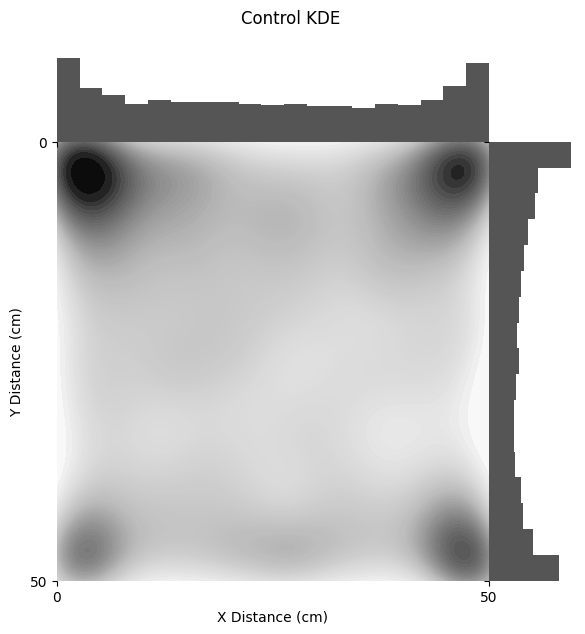

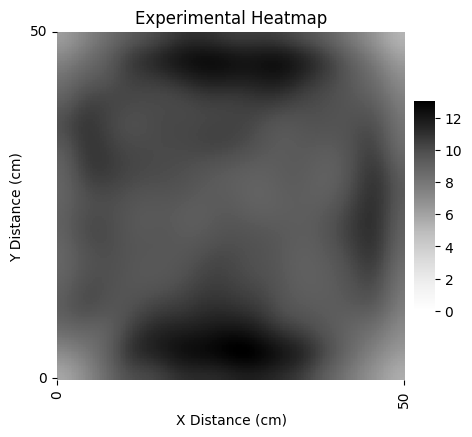

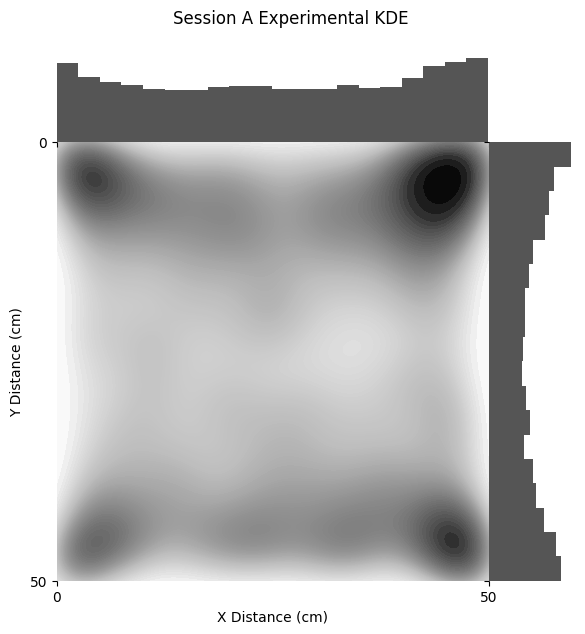

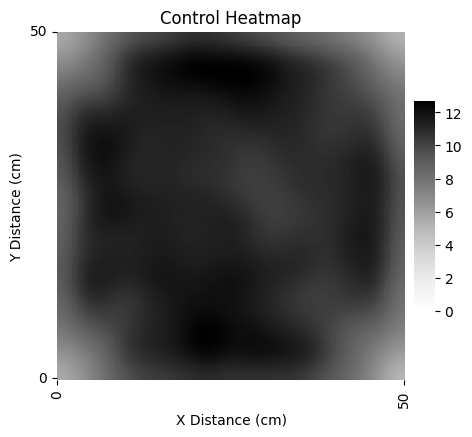

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Folder set
base_folder = r"Q:/sachuriga/CR_CA1_paper/Results/Locomotion"
session = "A"

# Load the data
df_loaded = pd.read_pickle('S:/Sachuriga/nwb/test4neo/test/speed_analysis_results.pkl')
df = df_loaded 

# Define control and experimental animal IDs
control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']

session = ["A"]

for session in session:
    # Filter for 'A' sessions
    if session == "Total":
        df_a = df
    else:
        df_a = df[df['session'] == session]

    # Separate into control and experimental groups
    control_df = df_a[df_a['animal_id'].isin(control_ids)]
    exp_df = df_a[df_a['animal_id'].isin(exp_ids)]

    # Set a consistent figure size
    FIG_SIZE = (6, 6)  # Width, Height in inches

    # First Plot: Control KDE (Top-Left)
    g1 = sns.JointGrid(data=df2results_sns(control_df), x="x", y="y", space=0, height=FIG_SIZE[1], ratio=5)
    g1.plot_joint(sns.kdeplot, fill=True, clip=((0, 1), (0, 1)), thresh=0, levels=100, cmap="Greys")
    g1.plot_marginals(sns.histplot, color=sns.color_palette("Greys")[-1], alpha=0.8, edgecolor="none")
    g1.ax_joint.set_xticks([0, 1])
    g1.ax_joint.set_xticklabels([0, 50])
    g1.ax_joint.set_yticks([0, 1])
    g1.ax_joint.set_yticklabels([50, 0])
    g1.ax_joint.set_xlabel('X Distance (cm)')
    g1.ax_joint.set_ylabel('Y Distance (cm)')
    g1.ax_joint.set_title('')  # Clear joint title to avoid overlap
    g1.figure.suptitle('Control KDE', y=1.05)  # Add title above the figure
    # Remove axis spines
    for spine in g1.ax_joint.spines.values():
        spine.set_visible(False)
    for spine in g1.ax_marg_x.spines.values():
        spine.set_visible(False)
    for spine in g1.ax_marg_y.spines.values():
        spine.set_visible(False)
    g1.figure.set_size_inches(FIG_SIZE)
    g1.figure.savefig(fr'{base_folder}/Session_{session}_control_activity_kde.pdf', format='pdf', bbox_inches='tight')
    g1.figure.savefig(fr'{base_folder}/Session_{session}_control_activity_kde.png', format='png', bbox_inches='tight', dpi=300)

    # Second Plot: Experimental Heatmap (Top-Right)
    fig2 = plt.figure(figsize=FIG_SIZE)
    ax2 = fig2.add_subplot(111)
    data_speedss_exp = df2results(exp_df)
    sns.heatmap(data_speedss_exp, cmap="Greys", annot=False, linewidths=0, vmin=0, ax=ax2, square=True,
                xticklabels=np.linspace(0, 50, 6), yticklabels=np.linspace(50, 0, 6),
                cbar_kws={'shrink': 0.5, 'aspect': 10, 'pad': 0.02})  # Adjusted colorbar padding
    n_rows, n_cols = data_speedss_exp.shape
    ax2.set_xticks([0, n_cols - 1])
    ax2.set_xticklabels([0, 50])
    ax2.set_yticks([0, n_rows - 1])
    ax2.set_yticklabels([50, 0])
    ax2.set_xlabel('X Distance (cm)')
    ax2.set_ylabel('Y Distance (cm)')
    ax2.set_title('Experimental Heatmap')  # Keep title on heatmap
    # Remove axis spines
    for spine in ax2.spines.values():
        spine.set_visible(False)
    fig2.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)  # Consistent margins
    fig2.savefig(fr'{base_folder}/Session_{session}_exp_heatmap.pdf', format='pdf', bbox_inches='tight')
    fig2.savefig(fr'{base_folder}/Session_{session}_exp_heatmap.png', format='png', bbox_inches='tight', dpi=300)

    # Third Plot: Experimental KDE (Bottom-Left)
    g3 = sns.JointGrid(data=df2results_sns(exp_df), x="x", y="y", space=0, height=FIG_SIZE[1], ratio=5)
    g3.plot_joint(sns.kdeplot, fill=True, clip=((0, 1), (0, 1)), thresh=0, levels=100, cmap="Greys")
    g3.plot_marginals(sns.histplot, color=sns.color_palette("Greys")[-1], alpha=0.8, edgecolor="none")
    g3.ax_joint.set_xticks([0, 1])
    g3.ax_joint.set_xticklabels([0, 50])
    g3.ax_joint.set_yticks([0, 1])
    g3.ax_joint.set_yticklabels([50, 0])
    g3.ax_joint.set_xlabel('X Distance (cm)')
    g3.ax_joint.set_ylabel('Y Distance (cm)')
    g3.ax_joint.set_title('')  # Clear joint title to avoid overlap
    g3.figure.suptitle(f'Session {session} Experimental KDE', y=1.05)  # Add title above the figure
    # Remove axis spines
    for spine in g3.ax_joint.spines.values():
        spine.set_visible(False)
    for spine in g3.ax_marg_x.spines.values():
        spine.set_visible(False)
    for spine in g3.ax_marg_y.spines.values():
        spine.set_visible(False)
    g3.figure.set_size_inches(FIG_SIZE)
    g3.figure.savefig(fr'{base_folder}/Session_{session}_exp_activity_kde.pdf', format='pdf', bbox_inches='tight')
    g3.figure.savefig(fr'{base_folder}/Session_{session}_exp_activity_kde.png', format='png', bbox_inches='tight', dpi=300)

    # Fourth Plot: Control Heatmap (Bottom-Right)
    fig4 = plt.figure(figsize=FIG_SIZE)
    ax4 = fig4.add_subplot(111)
    data_speedss_control = df2results(control_df)
    sns.heatmap(data_speedss_control, cmap="Greys", annot=False, linewidths=0, vmin=0, ax=ax4, square=True,
                xticklabels=np.linspace(0, 50, 6), yticklabels=np.linspace(50, 0, 6),
                cbar_kws={'shrink': 0.5, 'aspect': 10, 'pad': 0.02})  # Adjusted colorbar padding
    n_rows, n_cols = data_speedss_control.shape
    ax4.set_xticks([0, n_cols - 1])
    ax4.set_xticklabels([0, 50])
    ax4.set_yticks([0, n_rows - 1])
    ax4.set_yticklabels([50, 0])
    ax4.set_xlabel('X Distance (cm)')
    ax4.set_ylabel('Y Distance (cm)')
    ax4.set_title('Control Heatmap')  # Keep title on heatmap
    # Remove axis spines
    for spine in ax4.spines.values():
        spine.set_visible(False)
    fig4.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)  # Consistent margins
    fig4.savefig(fr'{base_folder}/Session_{session}_control_heatmap.pdf', format='pdf', bbox_inches='tight')
    fig4.savefig(fr'{base_folder}/Session_{session}_control_heatmap.png', format='png', bbox_inches='tight', dpi=300)

    # Display all plots
    plt.show()


Comparison for filter_speed_in_center:
Control mean: 10.50 ± 0.39
Experimental mean: 9.27 ± 0.33
Mann-Whitney U statistic: 925.00, p-value: 0.0095

Comparison for filter_speed_in_edge:
Control mean: 9.03 ± 0.33
Experimental mean: 8.99 ± 0.29
Mann-Whitney U statistic: 699.00, p-value: 0.8797

Comparison for center_border_ratio:
Control mean: 1.18 ± 0.03
Experimental mean: 1.03 ± 0.02
Mann-Whitney U statistic: 939.00, p-value: 0.0060

Comparison for active_times:
Control mean: 0.87 ± 0.01
Experimental mean: 0.87 ± 0.01
Mann-Whitney U statistic: 710.00, p-value: 0.7870

Comparison for mean_speed:
Control mean: 9.23 ± 0.34
Experimental mean: 9.02 ± 0.29
Mann-Whitney U statistic: 730.00, p-value: 0.6266

Comparison for time_in_center:
Control mean: 0.18 ± 0.01
Experimental mean: 0.19 ± 0.01
Mann-Whitney U statistic: 581.00, p-value: 0.2655


C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.1

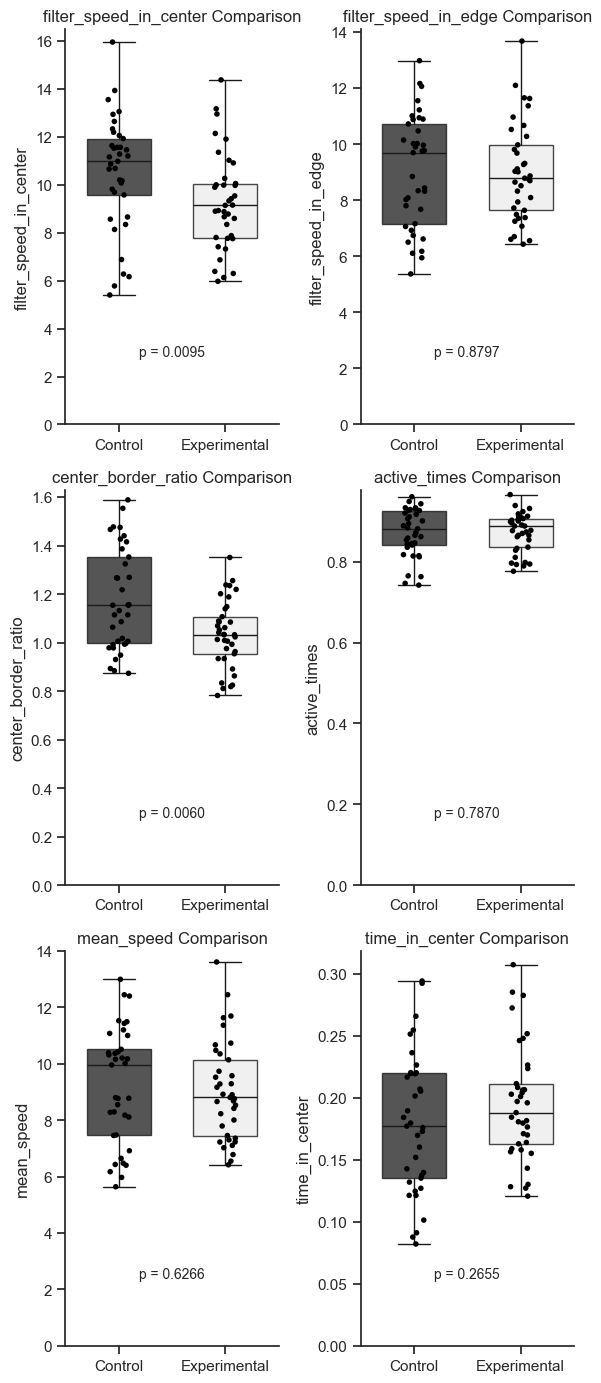


Comparison for filter_speed_in_center:
Control mean: 9.49 ± 0.41
Experimental mean: 9.89 ± 0.34
Mann-Whitney U statistic: 324.00, p-value: 0.4063

Comparison for filter_speed_in_edge:
Control mean: 8.65 ± 0.33
Experimental mean: 8.44 ± 0.30
Mann-Whitney U statistic: 416.00, p-value: 0.4863

Comparison for center_border_ratio:
Control mean: 1.09 ± 0.02
Experimental mean: 1.18 ± 0.02
Mann-Whitney U statistic: 246.00, p-value: 0.0324

Comparison for active_times:
Control mean: 0.87 ± 0.01
Experimental mean: 0.86 ± 0.01
Mann-Whitney U statistic: 432.00, p-value: 0.3347

Comparison for mean_speed:
Control mean: 8.80 ± 0.34
Experimental mean: 8.66 ± 0.30
Mann-Whitney U statistic: 399.00, p-value: 0.6811

Comparison for time_in_center:
Control mean: 0.19 ± 0.01
Experimental mean: 0.17 ± 0.01
Mann-Whitney U statistic: 467.00, p-value: 0.1207


C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.1

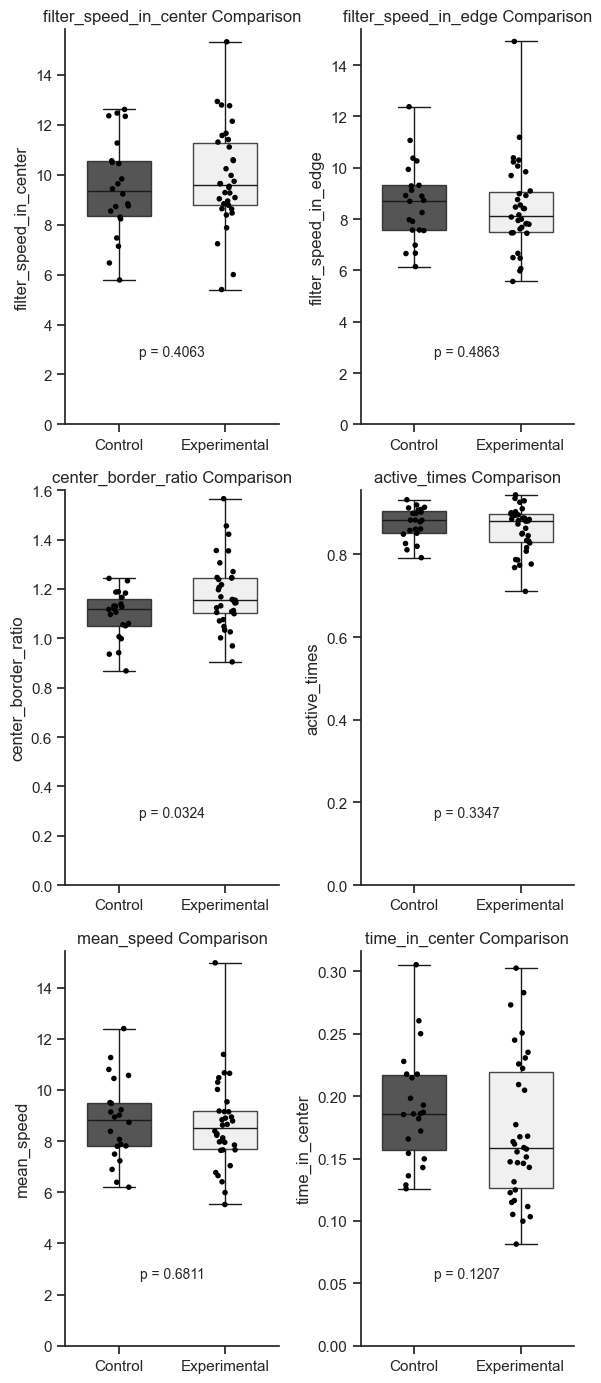


Comparison for filter_speed_in_center:
Control mean: 10.87 ± 0.52
Experimental mean: 8.56 ± 0.42
Mann-Whitney U statistic: 576.00, p-value: 0.0027

Comparison for filter_speed_in_edge:
Control mean: 10.28 ± 0.44
Experimental mean: 8.52 ± 0.37
Mann-Whitney U statistic: 560.00, p-value: 0.0061

Comparison for center_border_ratio:
Control mean: 1.05 ± 0.02
Experimental mean: 1.00 ± 0.03
Mann-Whitney U statistic: 495.00, p-value: 0.0923

Comparison for active_times:
Control mean: 0.90 ± 0.01
Experimental mean: 0.85 ± 0.01
Mann-Whitney U statistic: 539.00, p-value: 0.0164

Comparison for mean_speed:
Control mean: 10.39 ± 0.45
Experimental mean: 8.48 ± 0.37
Mann-Whitney U statistic: 572.00, p-value: 0.0033

Comparison for time_in_center:
Control mean: 0.23 ± 0.01
Experimental mean: 0.23 ± 0.01
Mann-Whitney U statistic: 403.00, p-value: 0.8516


C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.1

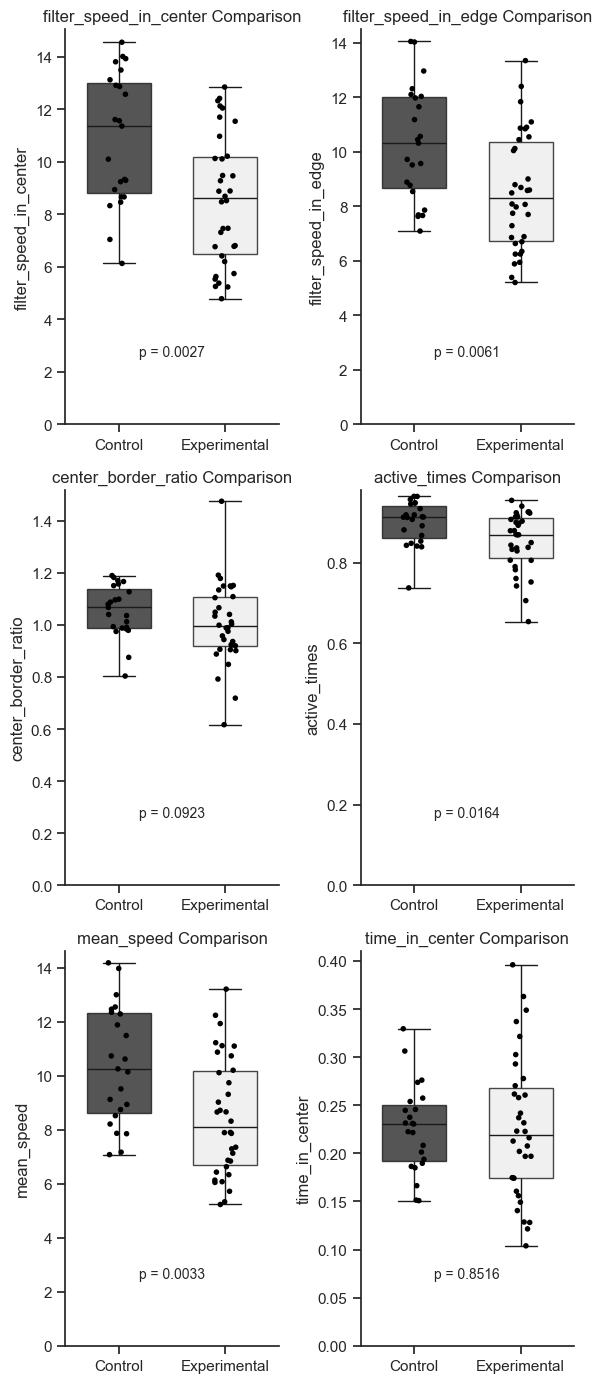


Comparison for filter_speed_in_center:
Control mean: 10.34 ± 0.26
Experimental mean: 9.24 ± 0.22
Mann-Whitney U statistic: 5442.00, p-value: 0.0020

Comparison for filter_speed_in_edge:
Control mean: 9.28 ± 0.22
Experimental mean: 8.66 ± 0.18
Mann-Whitney U statistic: 5083.00, p-value: 0.0343

Comparison for center_border_ratio:
Control mean: 1.12 ± 0.02
Experimental mean: 1.07 ± 0.02
Mann-Whitney U statistic: 4917.00, p-value: 0.0959

Comparison for active_times:
Control mean: 0.88 ± 0.01
Experimental mean: 0.86 ± 0.01
Mann-Whitney U statistic: 5067.00, p-value: 0.0381

Comparison for mean_speed:
Control mean: 9.44 ± 0.23
Experimental mean: 8.73 ± 0.19
Mann-Whitney U statistic: 5161.00, p-value: 0.0198

Comparison for time_in_center:
Control mean: 0.20 ± 0.01
Experimental mean: 0.20 ± 0.01
Mann-Whitney U statistic: 4383.00, p-value: 0.8329


C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\2720527184.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.1

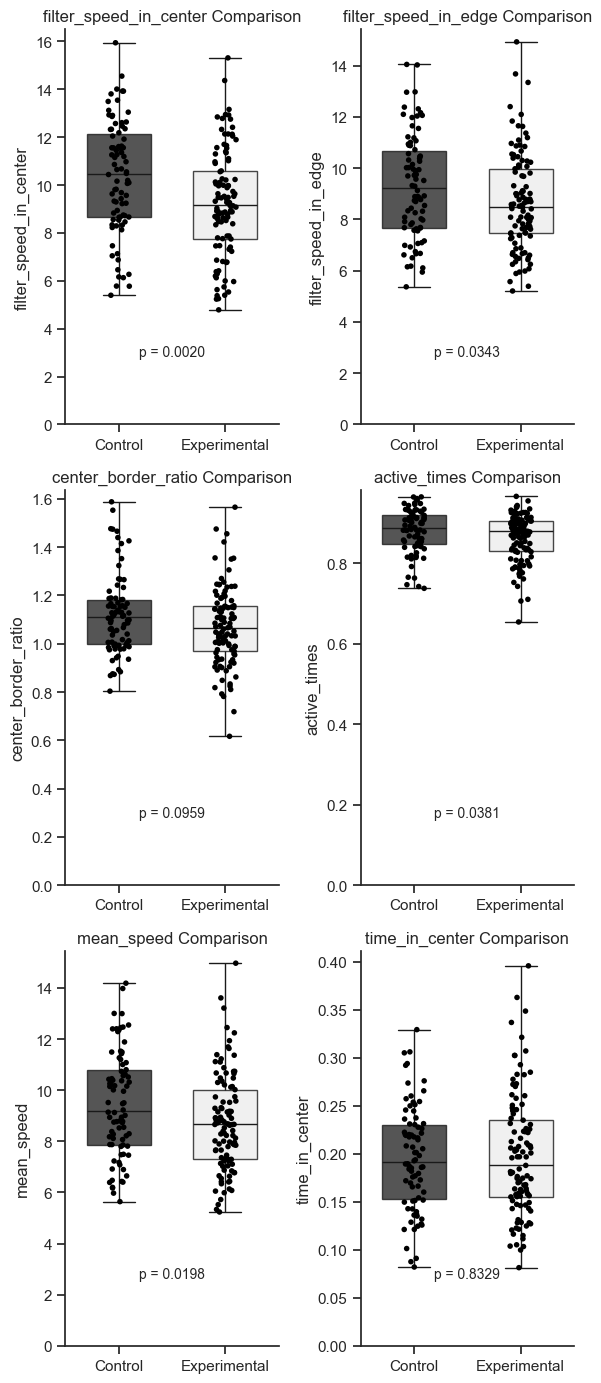

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

base_folder = r"Q:/sachuriga/CR_CA1_paper/Results/Locomotion"

# Load the data
df_loaded = pd.read_pickle('S:/Sachuriga/nwb/test4neo/test/speed_analysis_results.pkl')
df = df_loaded 

# Define control and experimental animal IDs
control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']

session = ["A","B","C","Total"]

for session in session:
    # Filter for 'A' sessions
    if session == "Total":
        df_a = df
    else:
        df_a = df[df['session'] == session]

    # Separate into control and experimental groups
    control_df = df_a[df_a['animal_id'].isin(control_ids)]
    exp_df = df_a[df_a['animal_id'].isin(exp_ids)]

    # Set Seaborn theme
    sns.set_theme(style="ticks")

    # Statistical comparisons for scalar metrics
    metrics = ['filter_speed_in_center', 'filter_speed_in_edge', 'center_border_ratio', 
            'active_times', 'mean_speed', 'time_in_center']

    # Create figure with 3x2 subplots
    fig, axes = plt.subplots(3, 2, figsize=(6, 14))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    # Define custom colors
    control_color = sns.color_palette("Greys")[-1]  # Dark blue for Control
    exp_color = sns.color_palette("Greys")[0]       # Light blue for Experimental

    for idx, metric in enumerate(metrics):
        control_values = control_df[metric].dropna()
        exp_values = exp_df[metric].dropna()
        
        if len(control_values) > 0 and len(exp_values) > 0:
            control_mean = control_values.mean()
            exp_mean = exp_values.mean()
            control_sem = control_values.sem()
            exp_sem = exp_values.sem()
            
            print(f"\nComparison for {metric}:")
            print(f"Control mean: {control_mean:.2f} ± {control_sem:.2f}")
            print(f"Experimental mean: {exp_mean:.2f} ± {exp_sem:.2f}")
            
            # Mann-Whitney U test
            u_stat, p_val = stats.mannwhitneyu(control_values, exp_values, alternative='two-sided')
            print(f"Mann-Whitney U statistic: {u_stat:.2f}, p-value: {p_val:.4f}")
            
            # Prepare data for Seaborn plotting
            plot_df = pd.DataFrame({
                'value': pd.concat([control_values, exp_values]),
                'group': ['Control'] * len(control_values) + ['Experimental'] * len(exp_values)
            })
            
            # Create vertical boxplot on the specific subplot
            boxplot = sns.boxplot(
                data=plot_df,
                x='group',
                y='value',
                ax=axes[idx],
                palette={"Control": control_color, "Experimental": exp_color},
                whis=[0, 100],
                width=.6
            )

            # Set the alpha (transparency) for the boxplot components
            for patch in boxplot.patches:
                patch.set_alpha(0.8)  # Set the alpha value here
            
            # Add individual points with matching colors
            
            # Add individual points with matching colors
            sns.stripplot(
                data=plot_df,
                x='group',
                y='value',
                ax=axes[idx],
                size=4,
                hue='group',  # Use hue to assign colors per group
                #palette={"Control": control_color, "Experimental": exp_color},  # Same colors as boxplot
                palette={"Control": "black", "Experimental": "black"},  # Same colors as boxplot
                alpha=1,
                legend=False  # Remove legend from stripplot
            )
            
            # Set title and labels
            axes[idx].set_title(f'{metric} Comparison')
            axes[idx].set_ylabel(metric)
            axes[idx].set_xlabel('Group')
            axes[idx].yaxis.grid(False)
            axes[idx].set(xlabel="")
            
            # Set y-axis to start from 0
            axes[idx].set_ylim(bottom=0, top=axes[idx].get_ylim()[1])  # Fixed 'custom' to 'bottom'
            
            # Add p-value at the top of the plot
            axes[idx].text(0.5, 0.2, f'p = {p_val:.4f}', 
                        horizontalalignment='center', 
                        verticalalignment='top', 
                        transform=axes[idx].transAxes, 
                        fontsize=10)
            
            # Remove top and right spines, keep bottom (x) and left (y) axes
            axes[idx].spines['top'].set_visible(False)
            axes[idx].spines['right'].set_visible(False)
            axes[idx].spines['bottom'].set_visible(True)  # Keep x-axis
            axes[idx].spines['left'].set_visible(True)    # Keep y-axis

    fig.savefig(fr'{base_folder}/{session}_sample4session_metrics_comparison.eps', format='eps', bbox_inches='tight')
    fig.savefig(fr'{base_folder}/{session}_sample4session_metrics_comparison.png', format='png', bbox_inches='tight')
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


Comparison for filter_speed_in_center:
Control mean (n=5): 9.70 ± 1.00
Experimental mean (n=5): 9.10 ± 0.68
Mann-Whitney U statistic: 15.00, p-value: 0.6905

Comparison for filter_speed_in_edge:
Control mean (n=5): 8.67 ± 0.75
Experimental mean (n=5): 8.77 ± 0.62
Mann-Whitney U statistic: 11.00, p-value: 0.8413

Comparison for center_border_ratio:
Control mean (n=5): 1.12 ± 0.08
Experimental mean (n=5): 1.04 ± 0.03
Mann-Whitney U statistic: 15.00, p-value: 0.6905

Comparison for active_times:
Control mean (n=5): 0.87 ± 0.02
Experimental mean (n=5): 0.87 ± 0.02
Mann-Whitney U statistic: 12.00, p-value: 1.0000

Comparison for mean_speed:
Control mean (n=5): 8.80 ± 0.78
Experimental mean (n=5): 8.81 ± 0.62
Mann-Whitney U statistic: 12.00, p-value: 1.0000

Comparison for time_in_center:
Control mean (n=5): 0.19 ± 0.01
Experimental mean (n=5): 0.20 ± 0.01
Mann-Whitney U statistic: 13.00, p-value: 1.0000


C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0.

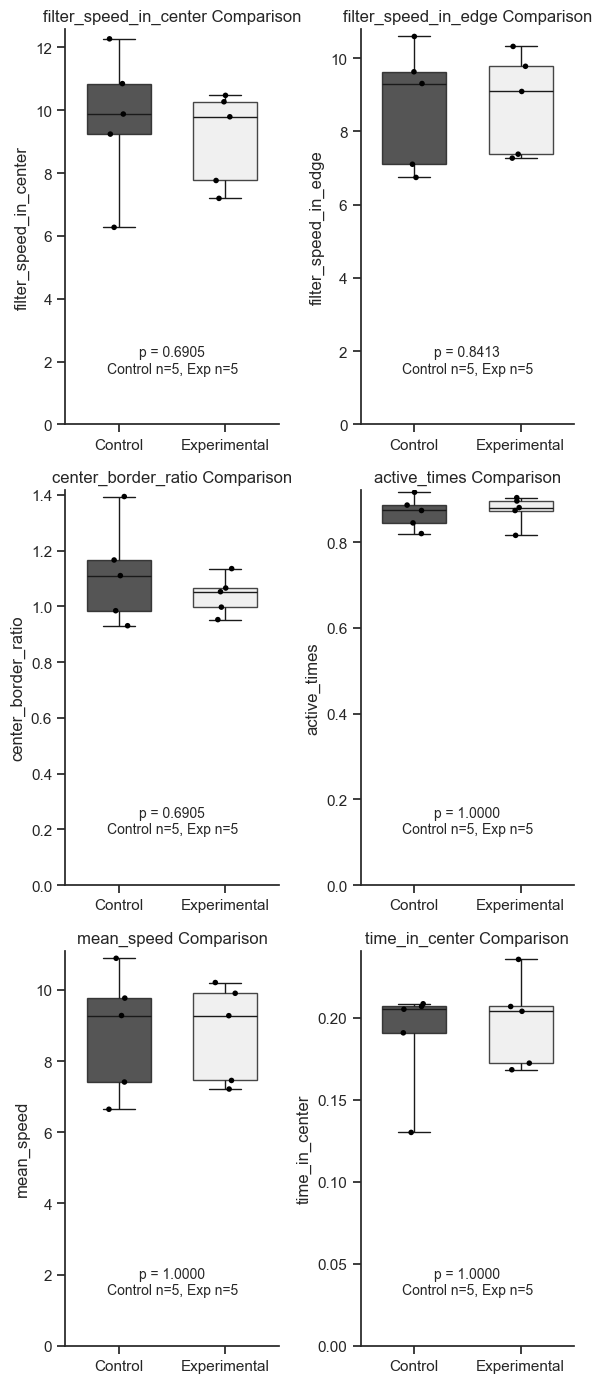


Comparison for filter_speed_in_center:
Control mean (n=4): 10.73 ± 0.94
Experimental mean (n=4): 9.95 ± 0.69
Mann-Whitney U statistic: 10.00, p-value: 0.6857

Comparison for filter_speed_in_edge:
Control mean (n=4): 9.30 ± 0.51
Experimental mean (n=4): 8.51 ± 0.62
Mann-Whitney U statistic: 11.00, p-value: 0.4857

Comparison for center_border_ratio:
Control mean (n=4): 1.15 ± 0.04
Experimental mean (n=4): 1.18 ± 0.01
Mann-Whitney U statistic: 7.00, p-value: 0.8857

Comparison for active_times:
Control mean (n=4): 0.90 ± 0.02
Experimental mean (n=4): 0.86 ± 0.02
Mann-Whitney U statistic: 11.00, p-value: 0.4857


C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0.


Comparison for mean_speed:
Control mean (n=4): 9.62 ± 0.62
Experimental mean (n=4): 8.73 ± 0.62
Mann-Whitney U statistic: 11.00, p-value: 0.4857

Comparison for time_in_center:
Control mean (n=4): 0.21 ± 0.02
Experimental mean (n=4): 0.17 ± 0.02
Mann-Whitney U statistic: 11.00, p-value: 0.4857


C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


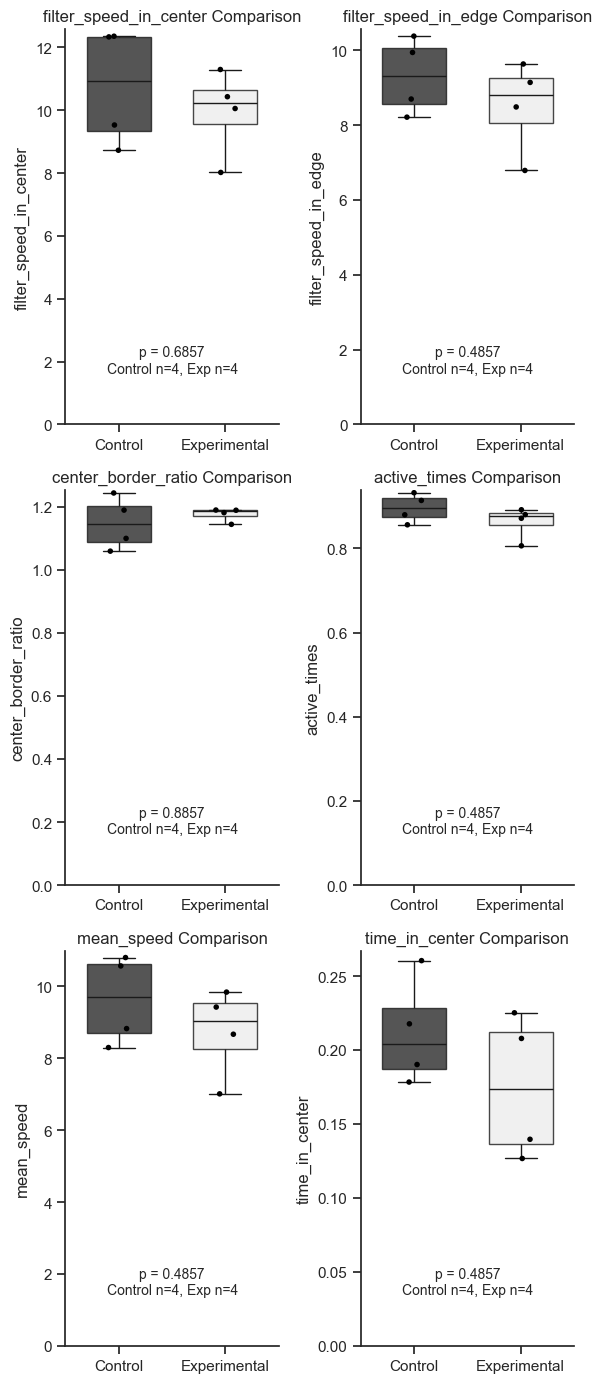


Comparison for filter_speed_in_center:
Control mean (n=4): 9.71 ± 0.93
Experimental mean (n=4): 8.90 ± 1.07
Mann-Whitney U statistic: 10.00, p-value: 0.6857

Comparison for filter_speed_in_edge:
Control mean (n=4): 9.10 ± 0.88
Experimental mean (n=4): 8.79 ± 0.96
Mann-Whitney U statistic: 9.00, p-value: 0.8857

Comparison for center_border_ratio:
Control mean (n=4): 1.07 ± 0.04
Experimental mean (n=4): 1.01 ± 0.04
Mann-Whitney U statistic: 10.00, p-value: 0.6857

Comparison for active_times:
Control mean (n=4): 0.88 ± 0.02
Experimental mean (n=4): 0.86 ± 0.03
Mann-Whitney U statistic: 8.00, p-value: 1.0000

Comparison for mean_speed:
Control mean (n=4): 9.19 ± 0.90
Experimental mean (n=4): 8.77 ± 0.98
Mann-Whitney U statistic: 9.00, p-value: 0.8857

Comparison for time_in_center:
Control mean (n=4): 0.22 ± 0.03
Experimental mean (n=4): 0.22 ± 0.01
Mann-Whitney U statistic: 9.00, p-value: 0.8857


C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0.

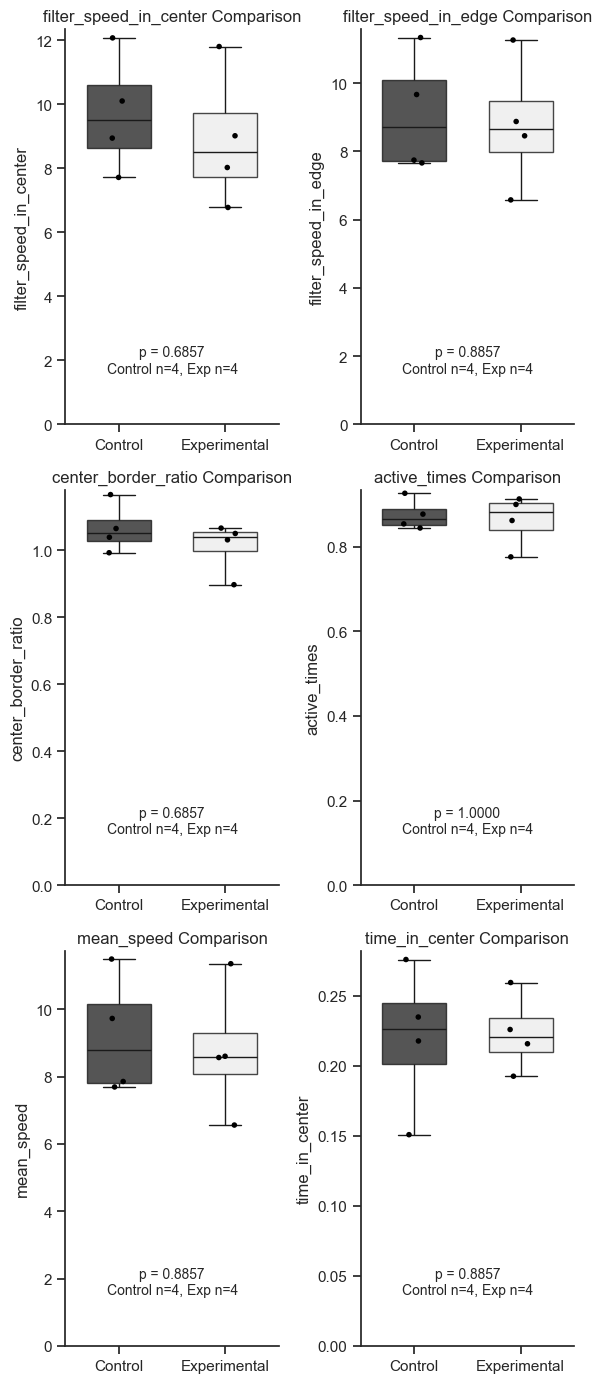


Comparison for filter_speed_in_center:
Control mean (n=5): 9.41 ± 0.85
Experimental mean (n=5): 9.10 ± 0.67
Mann-Whitney U statistic: 15.00, p-value: 0.6905

Comparison for filter_speed_in_edge:
Control mean (n=5): 8.52 ± 0.64
Experimental mean (n=5): 8.53 ± 0.62
Mann-Whitney U statistic: 12.00, p-value: 1.0000

Comparison for center_border_ratio:
Control mean (n=5): 1.10 ± 0.07
Experimental mean (n=5): 1.07 ± 0.02
Mann-Whitney U statistic: 14.00, p-value: 0.8413

Comparison for active_times:
Control mean (n=5): 0.87 ± 0.01
Experimental mean (n=5): 0.87 ± 0.02
Mann-Whitney U statistic: 10.00, p-value: 0.6905

Comparison for mean_speed:
Control mean (n=5): 8.63 ± 0.66
Experimental mean (n=5): 8.61 ± 0.62
Mann-Whitney U statistic: 13.00, p-value: 1.0000

Comparison for time_in_center:
Control mean (n=5): 0.20 ± 0.01
Experimental mean (n=5): 0.20 ± 0.01
Mann-Whitney U statistic: 12.00, p-value: 1.0000


C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\sachur\AppData\Local\Temp\ipykernel_19200\782168084.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0.

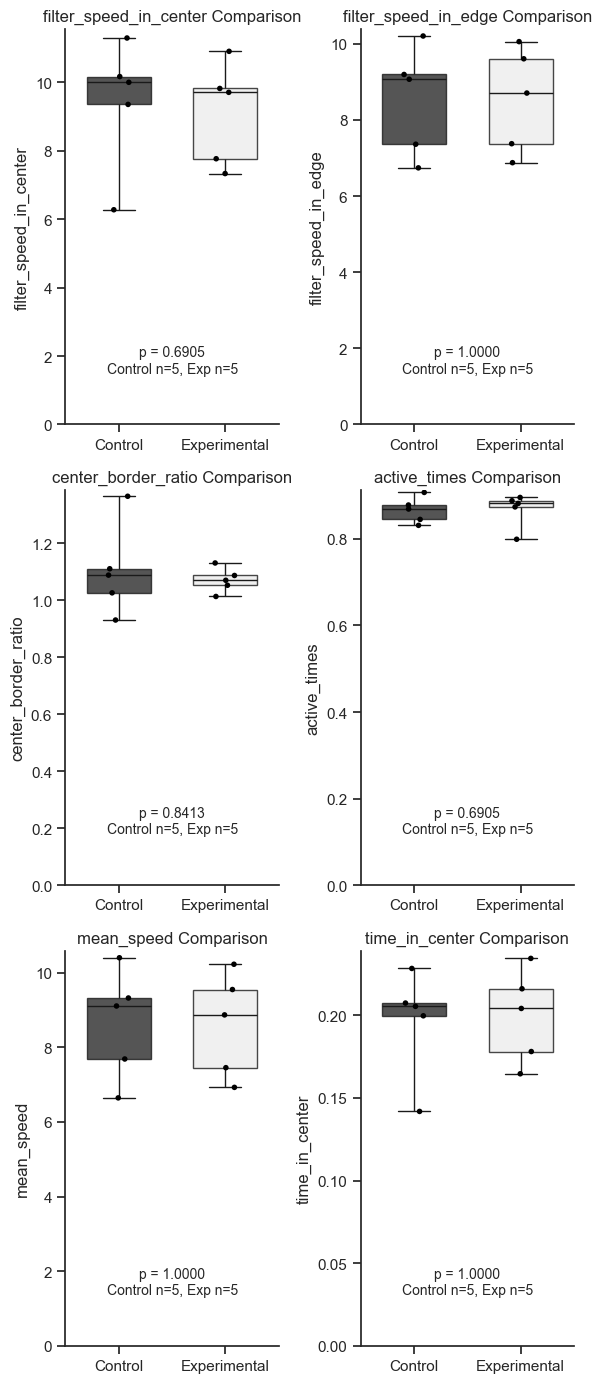

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# Set Seaborn theme
sns.set_theme(style="ticks")

# Define control and experimental animal IDs
control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']

base_folder = r"Q:/sachuriga/CR_CA1_paper/Results/Locomotion"

# Load the data
df_loaded = pd.read_pickle('S:/Sachuriga/nwb/test4neo/test/speed_analysis_results.pkl')
df = df_loaded 

# Define control and experimental animal IDs
control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']

session = ["A","B","C","Total"]

for session in session:
    
        # Filter for 'A' sessions
    if session == "Total":
        df_a = df
    else:
        df_a = df[df['session'] == session]

    # Separate into control and experimental groups
    control_df = df_a[df_a['animal_id'].isin(control_ids)]
    exp_df = df_a[df_a['animal_id'].isin(exp_ids)]
        
    # Assuming control_df and exp_df are already defined from previous context
    # Filter data for specific animal IDs and calculate mean per animal
    control_animals = control_df[control_df['animal_id'].isin(control_ids)].groupby('animal_id').mean(numeric_only=True)
    exp_animals = exp_df[exp_df['animal_id'].isin(exp_ids)].groupby('animal_id').mean(numeric_only=True)

    # Statistical comparisons for scalar metrics
    metrics = ['filter_speed_in_center', 'filter_speed_in_edge', 'center_border_ratio', 
            'active_times', 'mean_speed', 'time_in_center']

    # Create figure with 3x2 subplots
    fig, axes = plt.subplots(3, 2, figsize=(6, 14))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    # Define custom colors
    control_color = sns.color_palette("Greys")[-1]  # Dark blue for Control
    exp_color = sns.color_palette("Greys")[0]       # Light blue for Experimental


    for idx, metric in enumerate(metrics):
        # Get per-animal averages
        control_values = control_animals[metric].dropna()
        exp_values = exp_animals[metric].dropna()
        
        if len(control_values) > 0 and len(exp_values) > 0:
            control_mean = control_values.mean()
            exp_mean = exp_values.mean()
            control_sem = control_values.sem()
            exp_sem = exp_values.sem()
            
            # Sample sizes (number of animals)
            control_n = len(control_values)
            exp_n = len(exp_values)
            
            print(f"\nComparison for {metric}:")
            print(f"Control mean (n={control_n}): {control_mean:.2f} ± {control_sem:.2f}")
            print(f"Experimental mean (n={exp_n}): {exp_mean:.2f} ± {exp_sem:.2f}")
            
            # Mann-Whitney U test
            u_stat, p_val = stats.mannwhitneyu(control_values, exp_values, alternative='two-sided')
            print(f"Mann-Whitney U statistic: {u_stat:.2f}, p-value: {p_val:.4f}")
            
            # Prepare data for Seaborn plotting
            plot_df = pd.DataFrame({
                'value': pd.concat([control_values, exp_values]),
                'group': ['Control'] * len(control_values) + ['Experimental'] * len(exp_values)
            })
            
            # Create the boxplot without alpha
            boxplot = sns.boxplot(
                data=plot_df,
                x='group',
                y='value',
                ax=axes[idx],
                palette={"Control": control_color, "Experimental": exp_color},
                whis=[0, 100],
                width=.6
            )

            # Set the alpha (transparency) for the boxplot components
            for patch in boxplot.patches:
                patch.set_alpha(0.8)  # Set the alpha value here
            
            # Add individual points with matching colors
            sns.stripplot(
                data=plot_df,
                x='group',
                y='value',
                ax=axes[idx],
                size=4,
                hue='group',  # Use hue to assign colors per group
                #palette={"Control": control_color, "Experimental": exp_color},  # Same colors as boxplot
                palette={"Control": "black", "Experimental": "black"},  # Same colors as boxplot
                alpha=1,
                jitter=0.1,
                legend=False  # Remove legend from stripplot
            )
            
            # Set title and labels
            axes[idx].set_title(f'{metric} Comparison')
            axes[idx].set_ylabel(metric)
            axes[idx].set_xlabel('Group')
            axes[idx].yaxis.grid(False)
            axes[idx].set(xlabel="")
            
            # Set y-axis to start from 0
            axes[idx].set_ylim(bottom=0, top=axes[idx].get_ylim()[1])  # Fixed 'custom' to 'bottom'
            
            # Add p-value and sample sizes at the top of the plot
            axes[idx].text(0.5, 0.2, f'p = {p_val:.4f}\nControl n={control_n}, Exp n={exp_n}', 
                        horizontalalignment='center', 
                        verticalalignment='top', 
                        transform=axes[idx].transAxes, 
                        fontsize=10)
            
            # Remove top and right spines, keep bottom (x) and left (y) axes
            axes[idx].spines['top'].set_visible(False)
            axes[idx].spines['right'].set_visible(False)
            axes[idx].spines['bottom'].set_visible(True)  # Keep x-axis
            axes[idx].spines['left'].set_visible(True)    # Keep y-axis

    fig.savefig(fr'{base_folder}/{session}_sample4animal_metrics_comparison.eps', format='eps', bbox_inches='tight')
    fig.savefig(fr'{base_folder}/{session}_sample4animal_metrics_comparison.png', format='png', bbox_inches='tight')
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()